In [1]:
import os
import sys
import time
import math
import numpy as np
import pandas as pd
from shutil import copyfile
from statistics import mean
import matplotlib.pyplot as plt
import logging
import pickle

In [2]:
date = '23042022'
output_dir = os.path.join('gmdb_data/', date)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
input_dir = '../data'

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
log_file = os.path.join(output_dir, 'run.log')
logging.basicConfig(filename=log_file, format='%(asctime)s: %(name)s - %(message)s', datefmt='%m-%d %H:%M', level=logging.DEBUG, filemode='w')
console_handle = logging.StreamHandler()
console_handle.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s: %(message)s', datefmt='%m-%d %H:%M')
console_handle.setFormatter(formatter)
logger.addHandler(console_handle)

In [3]:
input_gmdb_file = os.path.join(input_dir, 'gestalt_matcher_photo_data_2022_4_23_155152.tsv')
morbid_file = os.path.join(input_dir, 'morbidmap.txt')
ps_file = os.path.join(input_dir, 'phenotypicSeries.txt')
title_file = os.path.join(input_dir, 'mimTitles.txt')

In [4]:
df = pd.read_csv(input_gmdb_file, sep='\t')

In [5]:
df.shape

(10551, 31)

# Check raw data
# Load test set and check duplicates
# Clean data
# Check again
# generate splits

In [6]:
with open('gmdb_embeddings_255_arcface_official_23042022_v1_fix.p', 'rb') as f:
    gmdb_arc_dict = pickle.load(f)
df = df[~df.apply(lambda r: True if (r.image_type == 'Frontal face') and (str(r.image_id) not in gmdb_arc_dict.keys()) else False, axis=1)]

In [7]:
df.shape

(10545, 31)

In [8]:
# Duplicates
with open('duplication_detection_file.p', 'rb') as f:
    gmdb_detect_dict = pickle.load(f)
duplicated_subject_ids = gmdb_detect_dict['removed_subjects'].keys()
duplicated_image_ids = [image_id for _, image_ids in gmdb_detect_dict['removed_subjects'].items() for image_id in image_ids]

print('Duplicated subject number: {}'.format(len(duplicated_subject_ids)))
print('Duplicated image number: {}'.format(len(duplicated_image_ids)))

df = df[df.apply(lambda r: True if r.image_id not in duplicated_image_ids else False, axis=1)]

Duplicated subject number: 244
Duplicated image number: 292


In [9]:
df.shape

(10253, 31)

In [10]:
def is_private(x):
    if (not pd.isnull(x.pmid) and x.pmid != '') or (not pd.isnull(x.doi) and x.doi != ''):
        # some publication
        return False

    if (not pd.isnull(x.private) and x.private == True):
        return True
    if (not pd.isnull(x.consent) and x.consent == False) and \
        ((pd.isnull(x.private)) or (not pd.isnull(x.private) and x.private == False)):
        return True
    else:
        return False
df[df.apply(lambda row : is_private(row), axis=1)].to_csv('private.csv', sep=',')

def no_consent(x):
    if (not pd.isnull(x.pmid) and x.pmid != '') or (not pd.isnull(x.doi) and x.doi != ''):
        # some publication
        return False

    if (not pd.isnull(x.consent) and x.consent == False):
        return True
    else:
        return False
df[df.apply(lambda row : no_consent(row), axis=1)].to_csv('no_concent.csv', sep=',')


# Distribution of File type

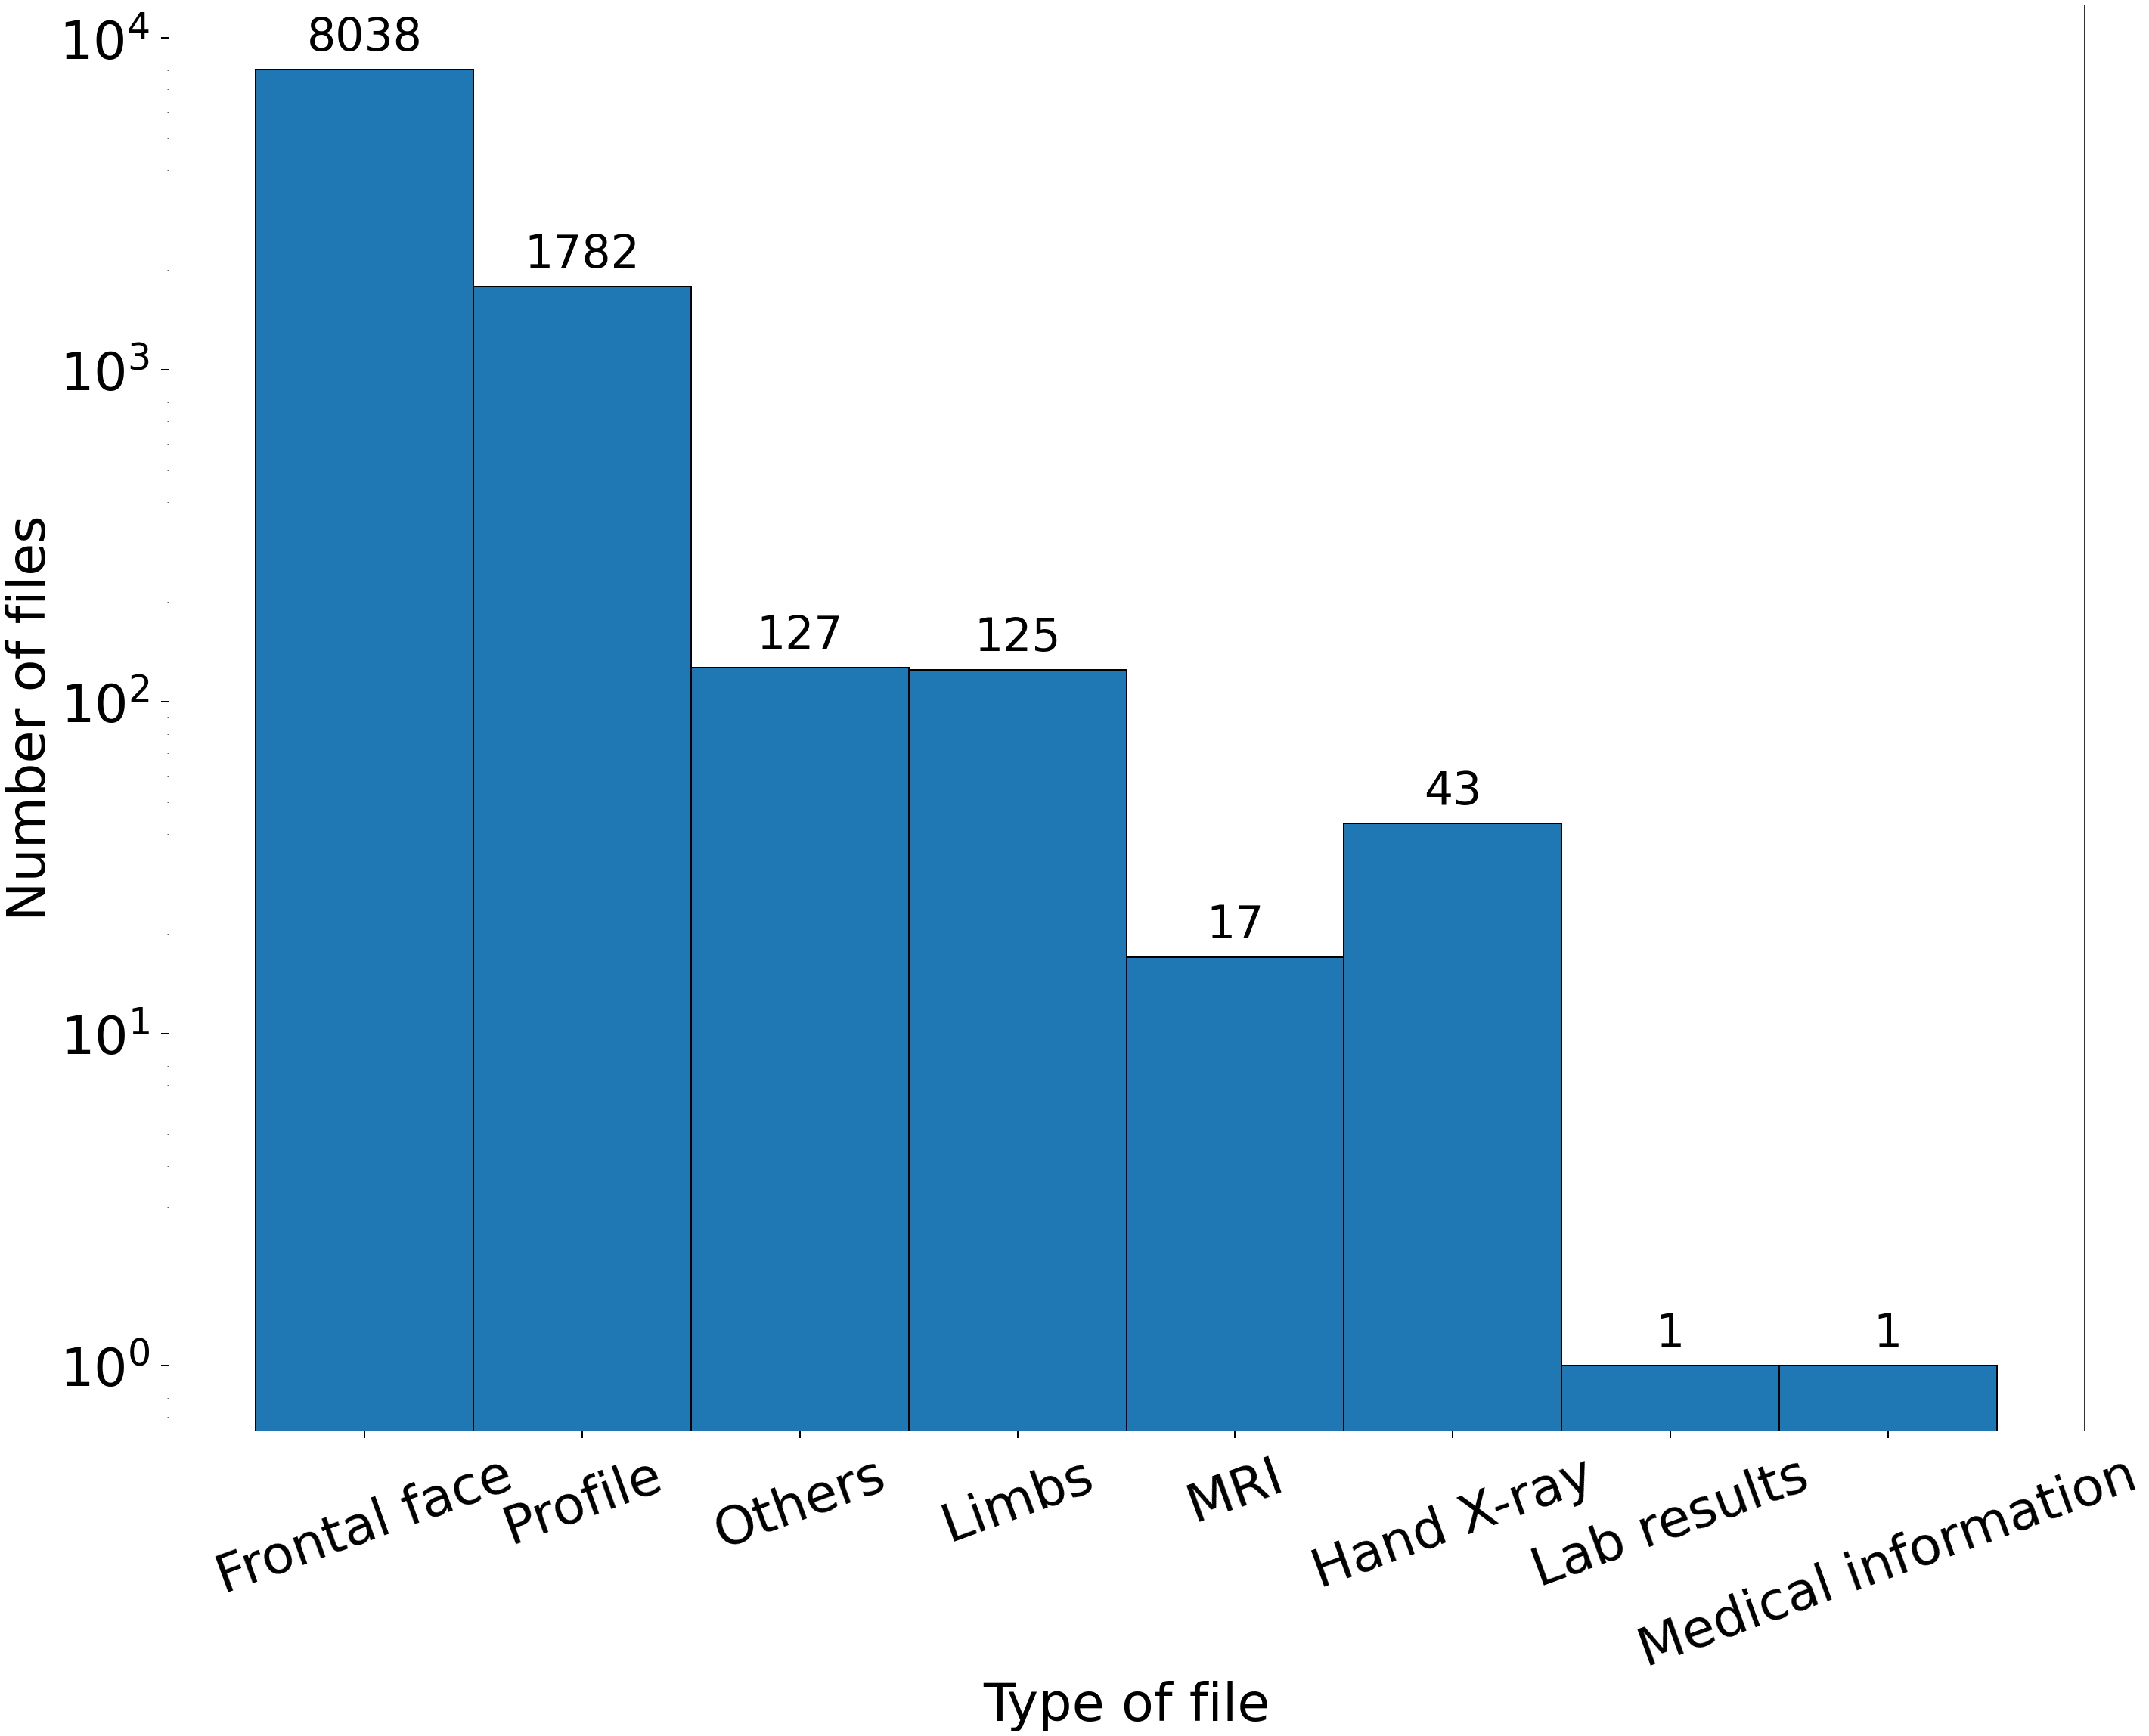

In [11]:
image_type_nums = df[~df.apply(lambda row : is_private(row), axis=1)]['image_type'].values
fig, ax = plt.subplots(figsize=(40, 32))
tick_size = 70
label_size = 70
num_bins = np.arange(0, len(np.unique(image_type_nums))+1) - 0.5
n, bins, patches = ax.hist(image_type_nums, bins=num_bins, edgecolor='black', linewidth=2)

# Add numbers on the top of each bar
for i in range(len(num_bins)-1):
    if n[i] > 0:
        ax.text(bins[i] + 0.5, n[i] * np.log10(14), str(int(n[i])), fontsize=60, ha='center')

ax.tick_params(pad=15, length=10, width=2, labelsize=tick_size)
ax.set_xlabel('Type of file', fontsize=label_size)
ax.set_ylabel('Number of files', fontsize=label_size)

#ax.set_xticks(np.arange(0, num_bins))
plt.setp(ax.get_xticklabels(), rotation=20)
ax.set_yscale('log')

fig.tight_layout()

fig.savefig(os.path.join(output_dir, 'file_type_public_summary_{}.png'.format(date)))
plt.show()


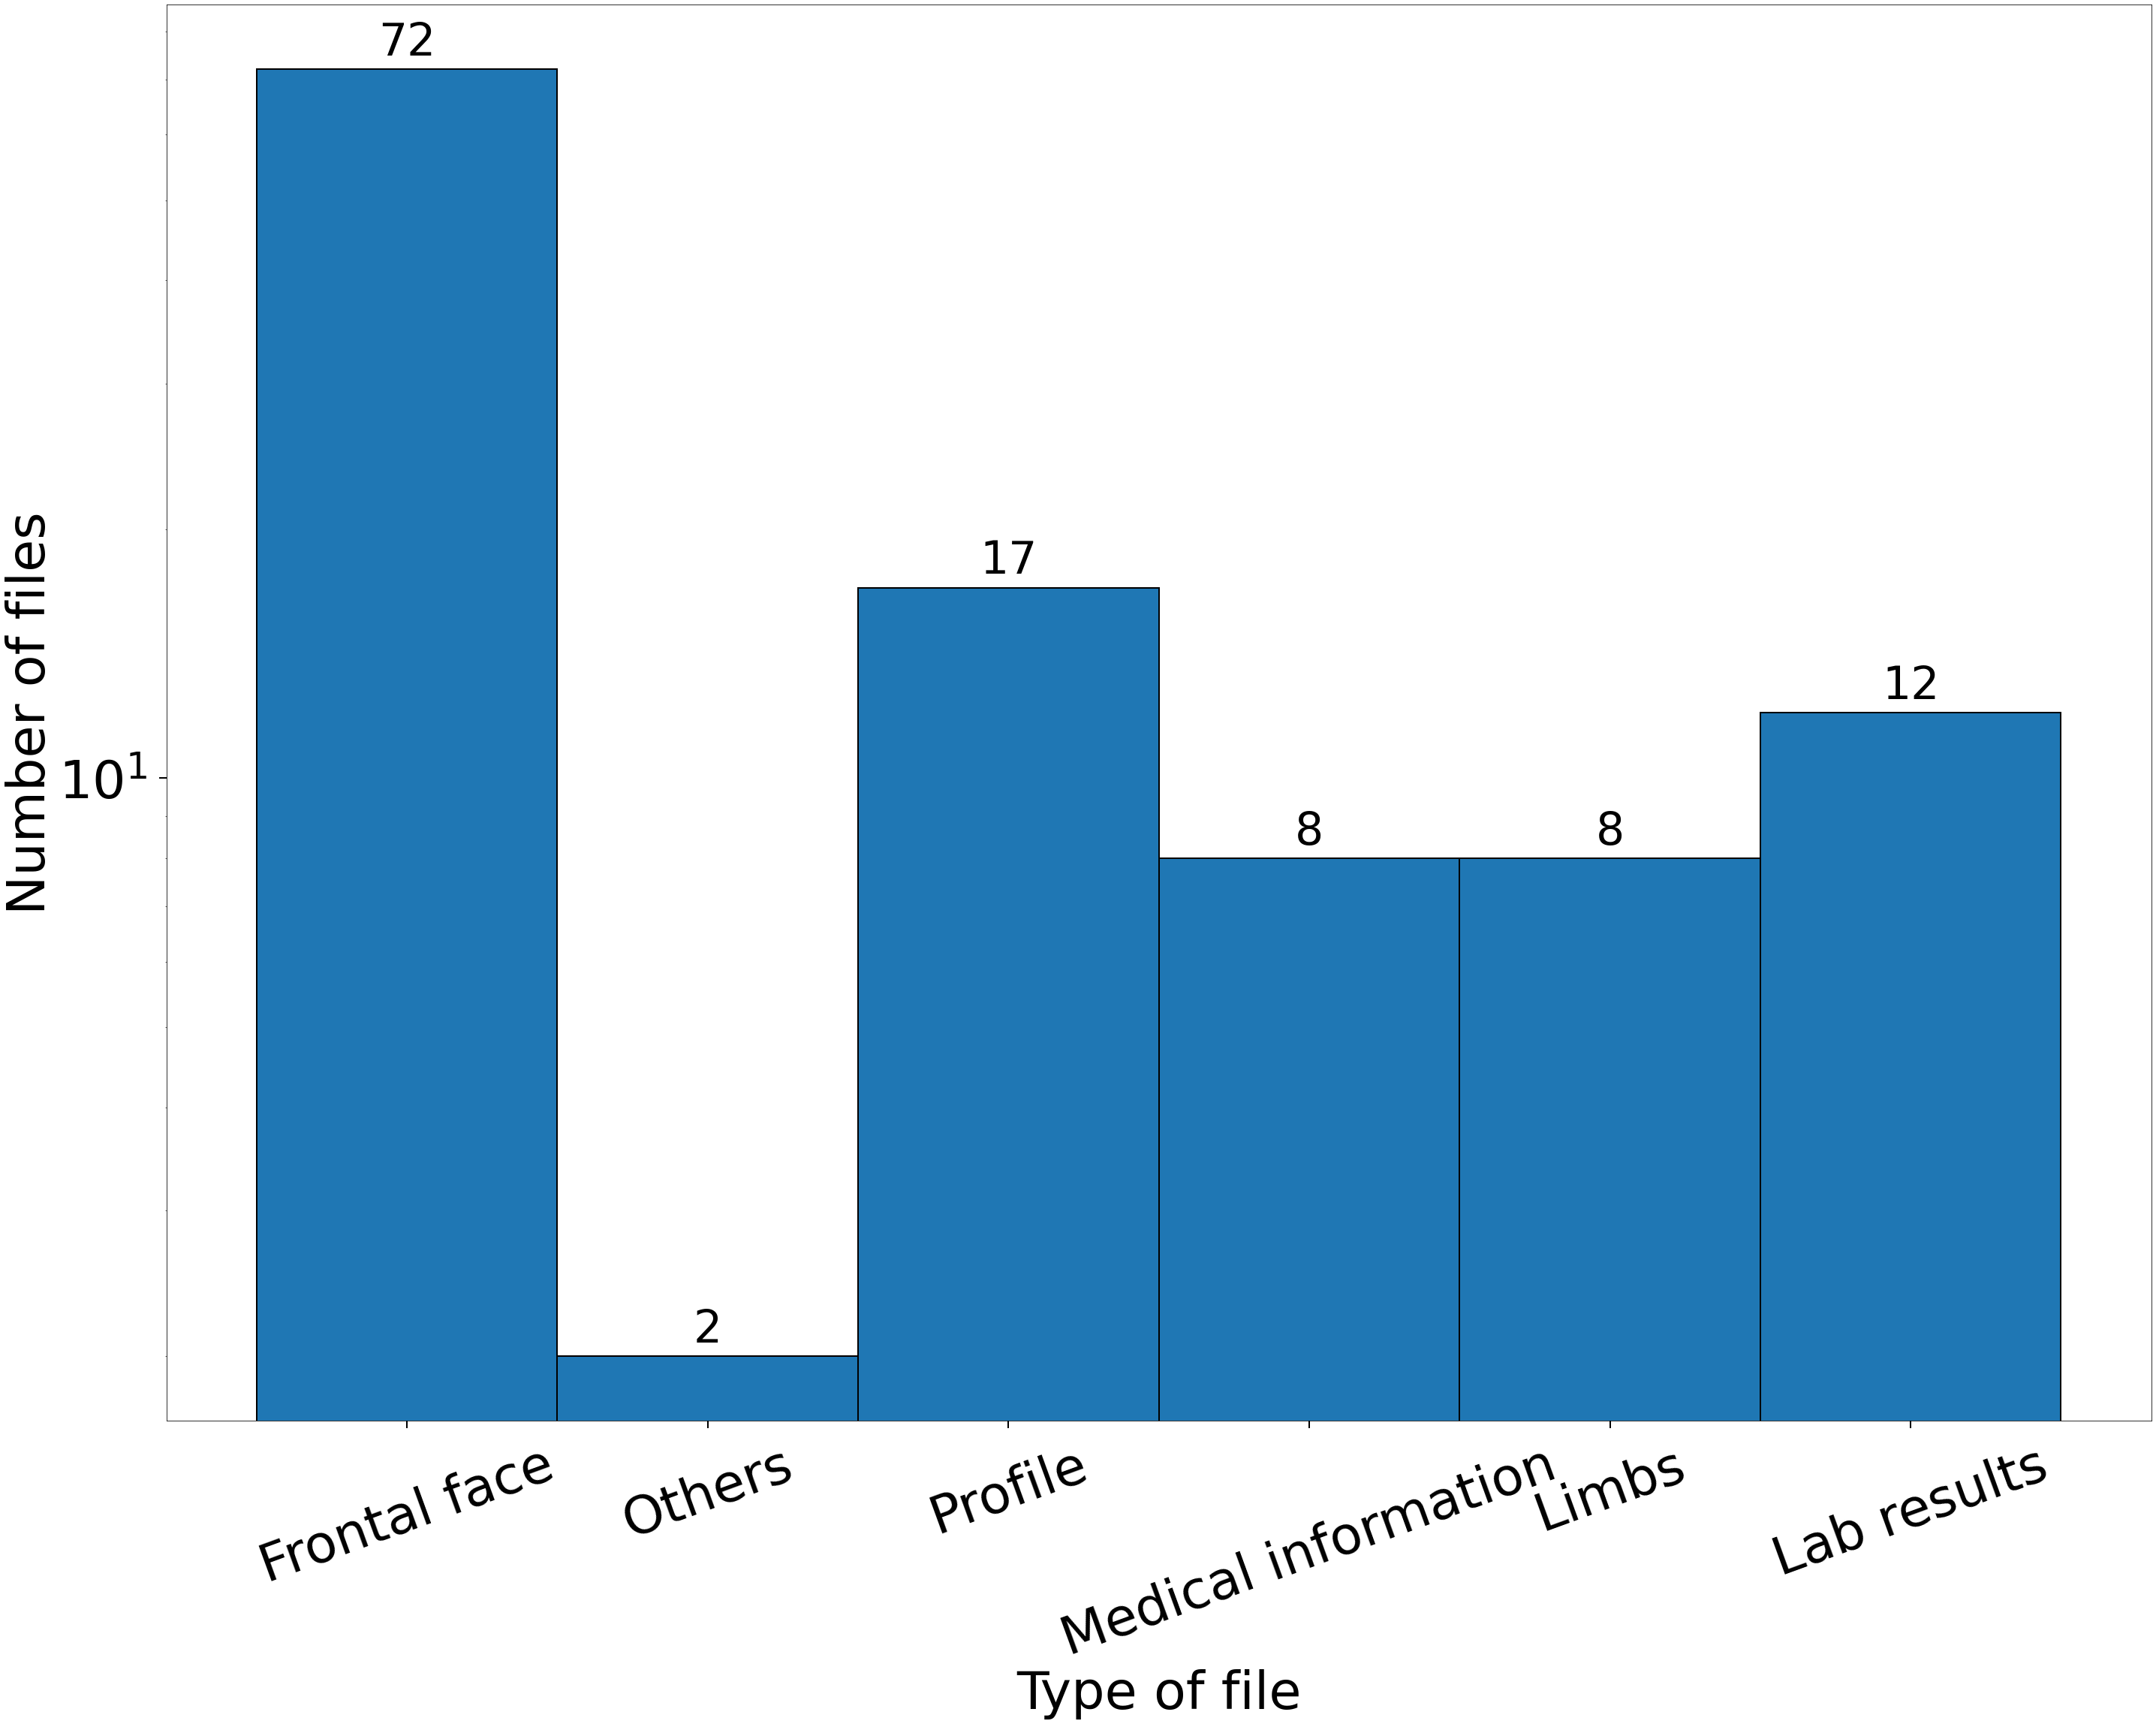

In [12]:
image_type_nums = df[df.apply(lambda row : is_private(row), axis=1)]['image_type'].values
fig, ax = plt.subplots(figsize=(40, 32))
tick_size = 70
label_size = 70
num_bins = np.arange(0, len(np.unique(image_type_nums))+1) - 0.5
n, bins, patches = ax.hist(image_type_nums, bins=num_bins, edgecolor='black', linewidth=2)

# Add numbers on the top of each bar
for i in range(len(num_bins)-1):
    if n[i] > 0:
        ax.text(bins[i] + 0.5, n[i] * np.log10(11), str(int(n[i])), fontsize=60, ha='center')

ax.tick_params(pad=15, length=10, width=2, labelsize=tick_size)
ax.set_xlabel('Type of file', fontsize=label_size)
ax.set_ylabel('Number of files', fontsize=label_size)

#ax.set_xticks(np.arange(0, num_bins))
plt.setp(ax.get_xticklabels(), rotation=20)
ax.set_yscale('log')

fig.tight_layout()

fig.savefig(os.path.join(output_dir, 'file_type_private_summary_{}.png'.format(date)))
plt.show()

# Distribution of frontal images

In [13]:
df = df[df.image_type=='Frontal face']
patient_ids = df.patient_id.values
image_ids = df.image_id.values
print('Number of patients: {}'.format(len(np.unique(patient_ids))))
print('Number of images: {}'.format(len(np.unique(image_ids))))

Number of patients: 6353
Number of images: 8110


In [14]:
class GMDB_publication(object):
    def __init__(self, gmdf, morbid_file, ps_file, title_file, gm_distinct_file, gmdf_score_file,
                 output_dir, date, logger):

        self.output_dir = output_dir
        self.date = date
        self.logger = logger

        # Read from GM paper
        self.app_df = pd.read_csv(gm_distinct_file, sep='\t')

        # Get grading scores
        score_df = pd.read_csv(os.path.join(gmdf_score_file), sep='\t')
        self.score_dict = {row['GENE']: (row['NE']+row['SM']+row['Karen'])/3 for index, row in score_df.iterrows()}

        # read from GMDB
        #gmdf = pd.read_csv(input_gmdb_file, sep='\t')
        gmdf = gmdf[gmdf.image_type == 'Frontal face']
        gmdf = gmdf[~gmdf.apply(lambda r: self.is_private(r), axis=1)]
        self.gmdf = gmdf.replace(np.nan, '', regex=True)
        self.gmdf['score'] = self.gmdf.apply(lambda x: self.get_score(x), axis=1)
        self.morbid_df = pd.read_csv(morbid_file, skiprows=3, sep='\t')
        self.ps_df = pd.read_csv(ps_file, skiprows=2, sep='\t')
        self.title_df = pd.read_csv(title_file, skiprows=2, sep='\t')

        self.gene2disorder = {}
        self.disorder2ps = {}
        self.ps2disorder = {}
        self.ps_dict = {}
        self.omim2title = {}
        self.disorder2score = {}

        self.init_gene_disorders()
        self.init_ps2disorder()
        self.init_title()
        self.dump_publication_df()
        self.dump_gm_paper_distinct()

    def is_private(self, x):
        if (not pd.isnull(x.pmid) and x.pmid != '') or (not pd.isnull(x.doi) and x.doi != ''):
            # some publication
            return False

        if (not pd.isnull(x.private) and x.private == True):
            return True
        if (not pd.isnull(x.consent) and x.consent == False) and \
            ((pd.isnull(x.private)) or (not pd.isnull(x.private) and x.private == False)):
            return True
        else:
            return False
        
    def get_score(self, x):
        if x['gene_names'] in self.score_dict:
            score = self.score_dict[x['gene_names']]
        else:
            score = 0
        return score

    def init_gene_disorders(self):
        for index, row in self.morbid_df.iterrows():
            tmp = row['# Phenotype'].split(', ')
            if '(3)' not in row['# Phenotype']:
                continue
            omim_id = tmp[-1].split(' ')[0]
            if not omim_id.isdigit():
                continue
            genes = row['Gene Symbols'].split(', ')

            for g in genes:
                if g not in self.gene2disorder:
                    self.gene2disorder[g] = []
                if int(omim_id) not in self.gene2disorder[g]:
                    self.gene2disorder[g].append(int(omim_id))

    def get_min_ps(self, synd_id):
        min_ps = ''
        min_len = 10000
        for i in self.disorder2ps[synd_id]:
            if len(self.ps2disorder[i]) < min_len:
                min_len = len(self.ps2disorder[i])
                min_ps = i
        return min_ps

    def init_disorder2score(self):
        for index, row in self.images_df.iterrows():
            if row['score'] == 0:
                continue
            if row['disorders'] not in self.disorder2score:
                self.disorder2score[row['disorders']] = [row['score']]
            else:
                self.disorder2score[row['disorders']].append(row['score'])

    def init_ps2disorder(self):
        for index, row in self.ps_df.iterrows():
            ps = row['# Phenotypic Series Number'][2:]
            omim_id = row['MIM Number']
            if omim_id.isdigit():
                # child
                omim_id = int(omim_id)
                if omim_id not in self.disorder2ps:
                    self.disorder2ps[omim_id] = []
                if int(ps) not in self.disorder2ps[omim_id]:
                    self.disorder2ps[omim_id].append(int(ps))
                if int(ps) not in self.ps2disorder:
                    self.ps2disorder[int(ps)] = []
                if int(omim_id) not in self.ps2disorder[int(ps)]:
                    self.ps2disorder[int(ps)].append(int(omim_id))
            else:
                # ps
                self.ps_dict[int(ps)] = omim_id
        self.ps_dict[176670] = 'Hutchinson-Gilford progeria'

    def init_title(self):
        for index, row in self.title_df.iterrows():
            omim_id = row['MIM Number']
            title = row['Preferred Title; symbol']
            self.omim2title[omim_id] = title

    def get_synd_name(self, synd_id):
        if synd_id in self.ps_dict:
            return self.ps_dict[synd_id]
        else:
            return self.omim2title[synd_id]


    def get_ps(self, synd_ids):
        output = []
        has_ps = False
        # check whether has ps

        for i in synd_ids:
            if 'PS' in i:
                i = i[2:]
                i = int(i)
                if len(self.ps2disorder[i]) > 30 and i != 213300:
                    continue
                output.append(i)
                has_ps = True
        if has_ps == False:
            for i in synd_ids:
                if 'PS' in i:
                    i = i[2:]
                i = int(i)
                if i not in self.disorder2ps:
                    output.append(i)
                else:
                    min_ps = self.get_min_ps(i)
                    if len(self.ps2disorder[min_ps]) > 30 and min_ps != 213300:
                        output.append(i)
                    else:
                        output.append(self.get_min_ps(i))
        return list(set(output))

    def get_score_by_disorder(self, x):
        if x['disorders'] in self.disorder2score:
            score = mean(self.disorder2score[x['disorders']])
        elif x['disorders'] in self.score_dict:
            score = self.score_dict[x['disorders']]
        else:
            score = None
        return score

    def get_selected(self, x):
        tmp_df = self.app_df[self.app_df.omim_id == x['disorder_ids']]
        if len(tmp_df) > 0 and tmp_df['select for test set'].values[0] == 1:
            selected_flag = 1
        else:
            selected_flag = None
        return selected_flag

    def get_paper_score_by_disorder(self, x):
        tmp_df = self.app_df[self.app_df.omim_id == x['disorder_ids']]
        if len(tmp_df) == 1:
            score = tmp_df['average'].values[0]
        elif len(tmp_df) > 1:
            print(x['disorder_ids'])
        else:
            score = None
        return score

    def dump_publication_df(self):
        counter = 0
        merged_data = []
        c = 0
        multi_disorder = []
        for index, row in self.gmdf.iterrows():
            # check if private
            if self.is_private(row):
                continue
            
            #print(row['omim_ids'])
            omim_ids = [i for i in row['omim_ids'].split(', ') if i != '']
            gene_names = [i for i in row['gene_names'].split(', ') if i != '']
            image_data = {'image_id': row['image_id'],
                          'patient_id': row['patient_id'],
                          'filename': row['filename'],
                          'disorders': [],
                          'disorder_ids': [],
                          'gender': row['gender'],
                          'score': row['score']}
            if len(omim_ids) > 0:
                # check syndrome and ps
                synds = self.get_ps(omim_ids)
                if len(synds) > 1:
                    synds = synds
                    counter += 1
                image_data['disorders'] = [self.get_synd_name(int(i)) for i in synds][0]
                image_data['disorder_ids'] = synds[0]
            elif len(omim_ids) == 0 and len(gene_names) > 0:
                gene = gene_names[0]
                if (gene not in self.gene2disorder) or (gene == 'NFIX'):
                    # use gene name as disorder
                    image_data['disorders'] = gene
                    image_data['disorder_ids'] = ''
                else:
                    if len(self.gene2disorder[gene]) == 1:
                        omim_ids = [str(self.gene2disorder[gene][0])]
                        synds = self.get_ps(omim_ids)
                        if len(synds) > 1:
                            synds = synds
                            counter += 1
                        image_data['disorders'] = [self.get_synd_name(int(i)) for i in synds][0]
                        image_data['disorder_ids'] = synds[0]
                    else:
                        c += 1
                        error_data = {'image_id': row['image_id'],
                                      'patient_id': row['patient_id'],
                                      'submitter': row['username'],
                                      'pmid': row['pmid'],
                                      'gene': gene}
                        multi_disorder.append(error_data)
                        continue
            else:
                # something wrong
                continue
            merged_data.append(image_data)

        # dump multi disorder file
        self.dump_multi_disorder(multi_disorder)

        self.images_df = pd.DataFrame(merged_data)
        self.init_disorder2score()
        self.disorder_df = self.images_df[['patient_id', 'disorders', 'disorder_ids']].drop_duplicates(subset=['patient_id'])
        self.disorder_df = self.disorder_df.groupby(['disorders', 'disorder_ids']).count().sort_values(['patient_id'],
                                                                                             ascending=False).reset_index()
        self.disorder_df['test_set_in_paper'] = self.disorder_df.apply(lambda x: self.get_selected(x), axis=1)
        self.disorder_df['gmdb_score'] = self.disorder_df.apply(lambda x: self.get_score_by_disorder(x), axis=1)
        self.disorder_df['paper_score'] = self.disorder_df.apply(lambda x: self.get_paper_score_by_disorder(x), axis=1)
        self.disorder_df.rename(columns={'patient_id': 'patient_count'}, inplace=True)
        self.dump_disorder_file()

    def dump_disorder_file(self):
        # dump to file
        disorder_summary_file = os.path.join(self.output_dir, 'disorders_summary_{}.csv'.format(self.date))
        self.disorder_df.to_csv(disorder_summary_file)
        self.logger.info('Dump disorder summary in: {}'.format(disorder_summary_file))

    def dump_multi_disorder(self, multi_disorder):
        self.multi_df = pd.DataFrame(multi_disorder).sort_values(by='submitter')
        multi_disorder_file = os.path.join(self.output_dir, 'gene_map_to_multi_disorders_{}.csv'.format(self.date))
        self.multi_df.to_csv(multi_disorder_file)
        self.logger.info('Dump multi-disorder summary in: {}'.format(multi_disorder_file))

    def dump_gm_paper_distinct(self):
        counts = []
        names = []
        omims = []
        index = 0

        for r_index, row in self.app_df.iterrows():
            count = 0
            omim = row['omim_id']
            selected_flag = row['select for test set']
            if omim in self.disorder_df['disorder_ids'].values:
                count = self.disorder_df[self.disorder_df['disorder_ids'] == omim]['patient_count'].values[0]
            if selected_flag == False:
                count = ''
            self.app_df.at[r_index, 'number of subjects in GMDB'] = count

        gm_distinct_file = os.path.join(self.output_dir, 'GM_paper_all_distinct_{}.csv'.format(self.date))
        self.app_df.to_csv(gm_distinct_file, index=False)
        self.logger.info('Dump gm paper distinct in: {}'.format(gm_distinct_file))

    def update_disorder_by_gmds(self, gmds):
        for synd_id in gmds.syndromes_metadata:
            synd_name = gmds.get_syndrome_name_by_synd_id(synd_id)
            num_of_subject = gmds.get_syndrome_num_subjects(synd_id)
            index = self.disorder_df[self.disorder_df.disorders == synd_name].index[0]
            self.disorder_df.loc[index, 'patient_count'] = num_of_subject
        self.dump_disorder_file()


    def plot_disorder_distribution(self):
        fig = plt.figure(figsize=(32, 16))
        ax = fig.add_subplot(1, 1, 1)
        x = self.disorder_df['patient_count']
        # the histogram of the data
        num_bins = np.append(np.array([0, 2, 7]), np.arange(10, max(x) + 5, 5))
        n, bins, patches = ax.hist(x, bins=num_bins)
        for i in range(len(num_bins) - 1):
            if n[i] > 0:
                plt.text(bins[i] + 2.5, n[i] + 2, str(int(n[i])), fontsize=20, ha='center')

        ax.set_xlabel('Number of subjects', fontsize=40)
        ax.set_ylabel('Number of disorders', fontsize=40)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.tick_params(axis='both', which='minor', labelsize=20)
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=7)
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.append(np.array([0, 2, 7]), np.arange(10, end, 10)))

        plt.savefig(os.path.join(self.output_dir, 'disorders_distribution_{}.jpg'.format(self.date)))


        fig = plt.figure(figsize=(32, 16))
        ax = fig.add_subplot(1, 1, 1)
        x = self.disorder_df['patient_count']
        # the histogram of the data
        num_bins = np.append(np.array([0, 2, 7]), np.arange(10, max(x) + 5, 5))
        n, bins, patches = ax.hist(x, bins=num_bins, cumulative=-1)
        for i in range(len(num_bins) - 1):
            if n[i] > 0:
                plt.text(bins[i] + 2.5, n[i] + 2, str(int(n[i])), fontsize=20, ha='center')

        ax.set_xlabel('Number of subjects', fontsize=40)
        ax.set_ylabel('Number of disorders', fontsize=40)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.tick_params(axis='both', which='minor', labelsize=20)
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=7)
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.append(np.array([0, 2, 7]), np.arange(10, end, 10)))

        plt.savefig(os.path.join(self.output_dir, 'disorders_survival_{}.jpg'.format(self.date)))

    def plot_distinct_scores_mapping(self):
        disorder_df = self.disorder_df.fillna(0)
        gmdb_scores = []
        paper_scores = []
        for index, row in disorder_df.iterrows():
            if row['gmdb_score'] == 0 or row['paper_score'] == 0:
                continue
            else:
                gmdb_scores.append(row['gmdb_score'])
                paper_scores.append(row['paper_score'])
        gmdb_scores = np.array(gmdb_scores)
        paper_scores = np.array(paper_scores)
        paper_scores_label = list(set(paper_scores))
        paper_scores_label.sort()
        gmdb_scores_label = list(set(gmdb_scores))
        gmdb_scores_label.sort()
        paper_mapping = {j: i for i, j in enumerate(paper_scores_label)}
        gmdb_mapping = {j: i for i, j in enumerate(gmdb_scores_label)}
        count_matrix = np.zeros((len(set(paper_scores)), len(set(gmdb_scores))), dtype=int)
        for i, j in zip(paper_scores, gmdb_scores):
            count_matrix[paper_mapping[i], gmdb_mapping[j]] += 1
        fig, ax = plt.subplots(figsize=(24, 16))
        plt.plot(paper_scores, gmdb_scores, 'o', alpha=0.2, markersize=16)
        for index_x, col in enumerate(count_matrix):
            for index_y, count in enumerate(col):
                if count > 0:
                    ax.annotate(count, (paper_scores_label[index_x] + 0.01, gmdb_scores_label[index_y] + 0.01),
                                fontsize=24)
        plt.xlabel('Distinctiveness scores in paper', fontsize=24)
        plt.ylabel('Distinctiveness scores in GMDB', fontsize=24)
        plt.title('Distinctiveness score in Paper and GMDB', fontsize=30)
        plt.savefig(os.path.join(self.output_dir, 'distinct_scores_paper_to_gmdb.png'))


05-04 11:37: Dump multi-disorder summary in: gmdb_data/23042022\gene_map_to_multi_disorders_23042022.csv
05-04 11:37: Dump disorder summary in: gmdb_data/23042022\disorders_summary_23042022.csv
05-04 11:37: Dump gm paper distinct in: gmdb_data/23042022\GM_paper_all_distinct_23042022.csv


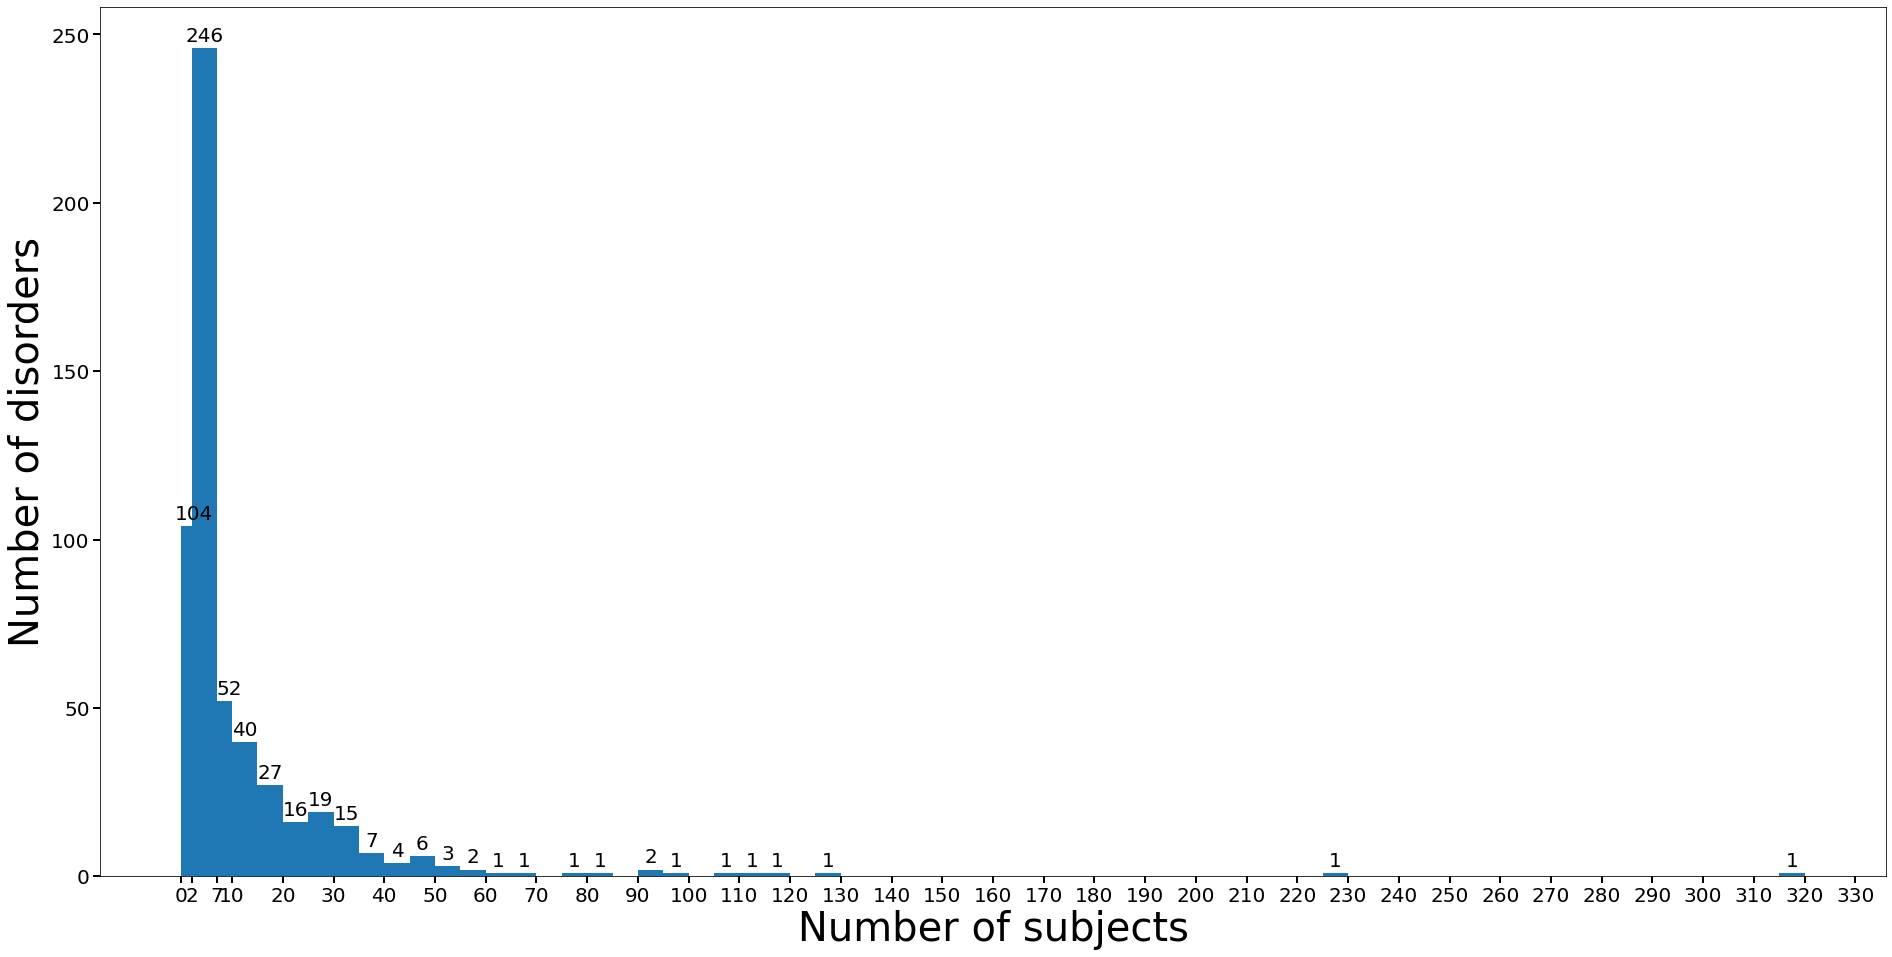

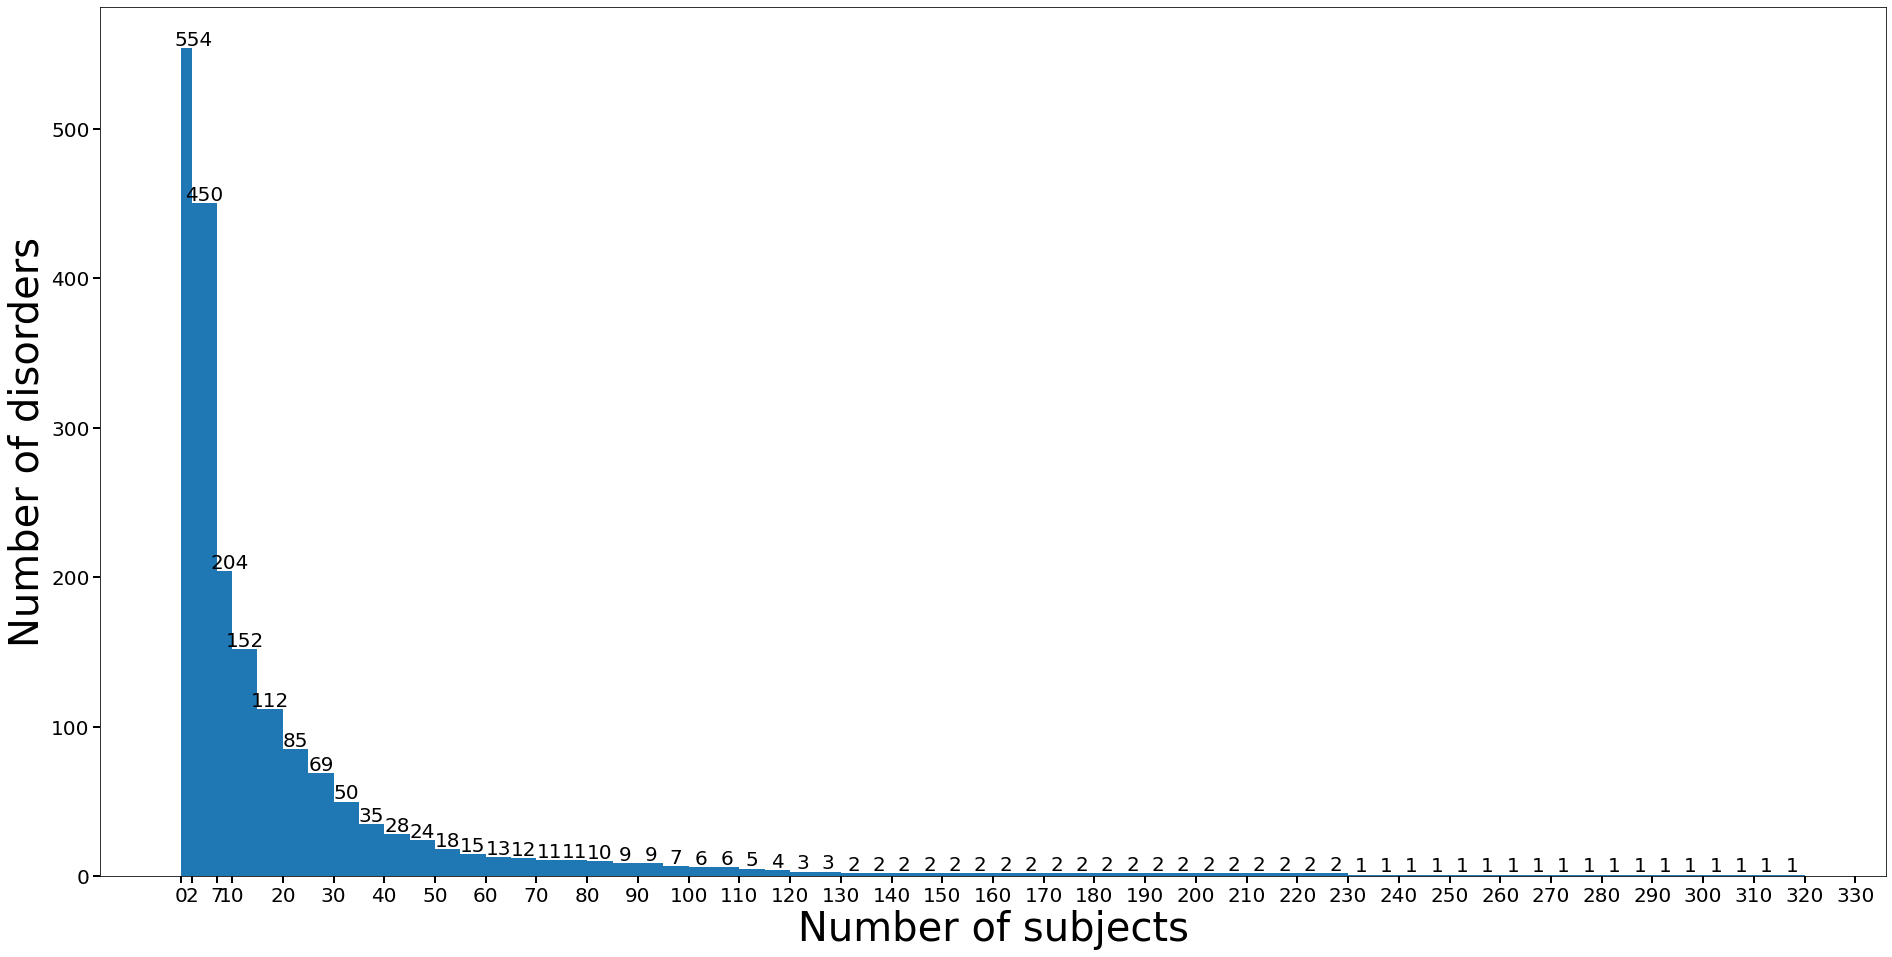

In [15]:
#input_gmdb_file = os.path.join(input_dir, 'gestalt_matcher_photo_data_2022_4_23_155152.tsv')
#df = pd.read_csv(input_gmdb_file, sep='\t')
omim_dir = '../data/omim/20042022'
morbid_file = os.path.join(omim_dir, 'morbidmap.txt')
ps_file = os.path.join(omim_dir, 'phenotypicSeries.txt')
title_file = os.path.join(omim_dir, 'mimTitles.txt')
gm_distinct_file = os.path.join('input_table', 'app_valid_296 syndromes - app_valid_third_version_curation.tsv')
gmdf_score_file = os.path.join('input_table', 'GMDB_grading_v1.txt')
gmdb = GMDB_publication(df, morbid_file, ps_file, title_file,
                        gm_distinct_file, gmdf_score_file, output_dir, date, logger)
#gmdb = GMDB_publication(input_gmdb_file, morbid_file, ps_file, title_file,
#                        gm_distinct_file, gmdf_score_file, output_dir, date, logger)
gmdb.plot_disorder_distribution()

In [16]:
rare_disorder_ids = gmdb.disorder_df[gmdb.disorder_df['patient_count'] > 6].disorders.values
ultra_disorder_ids = gmdb.disorder_df[(gmdb.disorder_df['patient_count'] <= 6) & (gmdb.disorder_df['patient_count'] >= 2)].disorders.values
print('Rare disorder: {}'.format(len(rare_disorder_ids)))
print('Ultra-rare disorder: {}'.format(len(ultra_disorder_ids)))

Rare disorder: 204
Ultra-rare disorder: 246


In [17]:
rare_df = gmdb.images_df[gmdb.images_df.apply(lambda r: True if r.disorders in rare_disorder_ids else False, axis=1)]
ultra_df = gmdb.images_df[gmdb.images_df.apply(lambda r: True if r.disorders in ultra_disorder_ids else False, axis=1)]

In [18]:
print('Rare subject: {}'.format(len(set(rare_df.patient_id.values))))
print('Rare image: {}'.format(len(set(rare_df.image_id.values))))
print('Ultra-rare subject: {}'.format(len(set(ultra_df.patient_id.values))))
print('Ultra-rare image: {}'.format(len(set(ultra_df.image_id.values))))

Rare subject: 5190
Rare image: 6617
Ultra-rare subject: 874
Ultra-rare image: 1117


In [19]:
disorder_name_to_id = {}
for idx, row in gmdb.disorder_df[gmdb.disorder_df['patient_count'] > 6].iterrows():
    disorder_name_to_id[row['disorders']] = idx

In [20]:
for idx, row in gmdb.disorder_df[(gmdb.disorder_df['patient_count'] <= 6) & (gmdb.disorder_df['patient_count'] >= 2)].iterrows():
    disorder_name_to_id[row['disorders']] = idx

In [21]:
previous_test_df = pd.read_csv('../data/GestaltMatcherDB/gmdb_test_images_v1.csv')
preserved_image_ids = previous_test_df.image_id.values
preserved_subject_ids = previous_test_df.subject.values

In [22]:
previous_blind_image_ids = [i for i in preserved_image_ids if i in rare_df.image_id.values]
previous_blind_subject_ids = set([i for i in preserved_subject_ids if i in rare_df.patient_id.values])

In [23]:
rare_df.loc[:,'disorder_id'] = [disorder_name_to_id[i] for i in rare_df['disorders'].values]
ultra_df.loc[:,'disorder_id'] = [disorder_name_to_id[i] for i in ultra_df['disorders'].values]

C:\Users\la60312\anaconda3\envs\train\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [24]:
rare_disorder_ids = gmdb.disorder_df[gmdb.disorder_df['patient_count'] > 6].index
ultra_disorder_ids = gmdb.disorder_df[(gmdb.disorder_df['patient_count'] <= 6) & (gmdb.disorder_df['patient_count'] >= 2)].index

In [25]:
image_id_to_subject_id = {}
for idx, row in rare_df.iterrows():
    image_id_to_subject_id[row['image_id']] = row['patient_id']
for idx, row in ultra_df.iterrows():
    image_id_to_subject_id[row['image_id']] = row['patient_id']
    
subject_id_to_image_id = {}
for idx, row in rare_df.iterrows():
    subject_id_to_image_id[row['patient_id']] = row['image_id']
for idx, row in ultra_df.iterrows():
    subject_id_to_image_id[row['patient_id']] = row['image_id']
    
synd_id_to_subject_ids = {}
for i in rare_disorder_ids:
    synd_id_to_subject_ids[i] = np.unique(rare_df[rare_df.disorder_id==i].patient_id.values)
for i in ultra_disorder_ids:
    synd_id_to_subject_ids[i] = np.unique(ultra_df[ultra_df.disorder_id==i].patient_id.values)
    
synd_id_to_image_ids = {}
for i in rare_disorder_ids:
    synd_id_to_image_ids[i] = rare_df[rare_df.disorder_id==i].image_id.values
for i in ultra_disorder_ids:
    synd_id_to_image_ids[i] = ultra_df[ultra_df.disorder_id==i].image_id.values
    
subject_id_to_synd_id = {}
for idx, row in rare_df.iterrows():
    subject_id_to_synd_id[row['patient_id']] = row['disorder_id']
for idx, row in ultra_df.iterrows():
    subject_id_to_synd_id[row['patient_id']] = row['disorder_id']

In [65]:
def get_subjects_for_split(subjects, split, total_num_splits=10):
    num_of_subjects = len(subjects)
    if num_of_subjects < total_num_splits:
        subjects = np.array([(list(subjects)*total_num_splits)[split]])
    else:
        subjects = subjects[np.arange(num_of_subjects) % total_num_splits == split]
    return np.array(subjects)

In [27]:
rand_seed = 1234
rare_synd_ids = np.unique(rare_df.disorder_id.values)

# Sample Test set
synd_blind_subject_ids = {}
for subject_id in previous_blind_subject_ids:
    synd_id = subject_id_to_synd_id[subject_id]
    if synd_id not in synd_blind_subject_ids:
        synd_blind_subject_ids[synd_id] = []
    synd_blind_subject_ids[synd_id].append(subject_id)

for synd_id in rare_synd_ids:
    synd_count = len(synd_id_to_subject_ids[synd_id])
    existed_blind_subject_ids = []
    if synd_id in synd_blind_subject_ids:
        existed_blind_subject_ids = synd_blind_subject_ids[synd_id]
    else:
        synd_blind_subject_ids[synd_id] = []
    blind_count = len(existed_blind_subject_ids)
    not_blind_subject_ids = [i for i in synd_id_to_subject_ids[synd_id] if i not in existed_blind_subject_ids]
    total_count = synd_count // 10
    if total_count == 0:
        total_count = 1
    to_add_count =  total_count - blind_count
    if to_add_count:
        add_subject_ids = np.random.RandomState(seed=rand_seed).permutation(not_blind_subject_ids)[:to_add_count]
        for subject_id in add_subject_ids:
            synd_blind_subject_ids[synd_id].append(subject_id)

In [70]:
# Sample Train and val
subjects_sampling = \
    {synd_id:
        np.random.RandomState(
            seed=rand_seed).permutation(
            list(set(synd_id_to_subject_ids[synd_id]) - set(synd_blind_subject_ids[synd_id])))
    for synd_id in rare_synd_ids}

# Cyclic completion of subjects to match number of splits
subjects_for_splits = \
    {synd_id: [get_subjects_for_split(subjects_sampling[synd_id], i)
              for i in range(10)]
    for synd_id in rare_synd_ids if len(subjects_sampling[synd_id])}

test_splits = \
        [np.concatenate(np.array(list(subjects_for_splits.values()), dtype=object)[:,i])
                for i in range(10)]
val = test_splits[0]
train_subjects = np.array(list(set(np.concatenate(np.array(list(subjects_sampling.values()), dtype=object))) - set(val)), dtype=object)
total_blind_subjects = np.concatenate(np.array(list(synd_blind_subject_ids.values()), dtype=object))

In [72]:
train_df = rare_df[rare_df.patient_id.isin(train_subjects)]
val_df = rare_df[rare_df.patient_id.isin(val)]
test_df = rare_df[rare_df.patient_id.isin(total_blind_subjects)]
train_df = train_df[['image_id', 'patient_id', 'disorder_id']]
val_df = val_df[['image_id', 'patient_id', 'disorder_id']]
test_df = test_df[['image_id', 'patient_id', 'disorder_id']]
train_df = train_df.rename(columns={'patient_id': 'subject', 'disorder_id': 'label'})
val_df = val_df.rename(columns={'patient_id': 'subject', 'disorder_id': 'label'})
test_df = test_df.rename(columns={'patient_id': 'subject', 'disorder_id': 'label'})
train_df.to_csv(os.path.join(output_dir, 'gmdb_train_images_v1.0.1.csv'), index=False)
val_df.to_csv(os.path.join(output_dir, 'gmdb_val_images_v1.0.1.csv'), index=False)
test_df.to_csv(os.path.join(output_dir, 'gmdb_test_images_v1.0.1.csv'), index=False)

# Rare gallery and test
rare_gallery_df = rare_df[rare_df.patient_id.isin(train_subjects) | rare_df.patient_id.isin(val)]
rare_test_df = rare_df[rare_df.patient_id.isin(total_blind_subjects)]
rare_gallery_df = rare_gallery_df[['image_id', 'patient_id', 'disorder_id']]
rare_test_df = rare_test_df[['image_id', 'patient_id', 'disorder_id']]
rare_gallery_df = rare_gallery_df.rename(columns={'patient_id': 'subject', 'disorder_id': 'label'})
rare_test_df = rare_test_df.rename(columns={'patient_id': 'subject', 'disorder_id': 'label'})
rare_gallery_df.to_csv(os.path.join(output_dir, 'gmdb_frequent_gallery_images_v1.0.1.csv'), index=False)
rare_test_df.to_csv(os.path.join(output_dir, 'gmdb_frequent_test_images_v1.0.1.csv'), index=False)

In [73]:
# Ultra rare
number_of_splits = 10
# Random sampling of subjects from each small syndrome
subjects_sampling = \
    {synd_id: np.random.RandomState(seed=rand_seed)
                .permutation(
                    [i for i in synd_id_to_subject_ids[synd_id]])
                    [:number_of_splits]
                    for synd_id in ultra_disorder_ids}

# Cyclic completion of subjects to match number of splits
subjects_for_splits = {synd_id: [subjects_sampling[synd_id]
                                 [i % len(subjects_sampling[synd_id])]
                                 for i in range(number_of_splits)]
                       for synd_id in ultra_disorder_ids if len(subjects_sampling[synd_id])}

# Build splits vectors
all_ultra_rare_subjects = np.unique(ultra_df.patient_id.values)
test_splits = np.stack(list(subjects_for_splits.values())).transpose()

ultra_rare_splits = {}
for split in range(number_of_splits):
    test_set = test_splits[split]
    gallery = list(set(all_ultra_rare_subjects) - set(test_set))
    ultra_rare_splits[split] = {'gallery': gallery, 'test': test_set}

In [74]:
# Ultra Rare gallery and test
for split in range(number_of_splits):
    gallery = ultra_rare_splits[split]['gallery']
    test = ultra_rare_splits[split]['test']
    gallery_df = ultra_df[ultra_df.patient_id.isin(gallery)]
    test_df = ultra_df[ultra_df.patient_id.isin(test)]
    gallery_df = gallery_df[['image_id', 'patient_id', 'disorder_id']]
    test_df = test_df[['image_id', 'patient_id', 'disorder_id']]
    gallery_df = gallery_df.rename(columns={'patient_id': 'subject', 'disorder_id': 'label'})
    test_df = test_df.rename(columns={'patient_id': 'subject', 'disorder_id': 'label'})
    gallery_df['split'] = split
    test_df['split'] = split
    print('Split {}, Gallery {}'.format(split, gallery_df.shape[0]))
    print('Split {}, Test {}'.format(split, test_df.shape[0]))
    if split == 0:
        ultra_rare_gallery_df = gallery_df
        ultra_rare_test = test_df
    else:
        ultra_rare_gallery_df = ultra_rare_gallery_df.append(gallery_df)
        ultra_rare_test = ultra_rare_test.append(test_df)

ultra_rare_gallery_df.to_csv(os.path.join(output_dir, 'gmdb_rare_gallery_images_v1.0.1.csv'), index=False)
ultra_rare_test.to_csv(os.path.join(output_dir, 'gmdb_rare_test_images_v1.0.1.csv'), index=False)

Split 0, Gallery 810
Split 0, Test 307
Split 1, Gallery 789
Split 1, Test 328
Split 2, Gallery 821
Split 2, Test 296
Split 3, Gallery 790
Split 3, Test 327
Split 4, Gallery 804
Split 4, Test 313
Split 5, Gallery 784
Split 5, Test 333
Split 6, Gallery 812
Split 6, Test 305
Split 7, Gallery 795
Split 7, Test 322
Split 8, Gallery 815
Split 8, Test 302
Split 9, Gallery 786
Split 9, Test 331


In [77]:
all_synd_ids = np.append(np.unique(rare_df.disorder_id.values), np.unique(ultra_df.disorder_id.values))

output_disorder_df = []

for synd_id in all_synd_ids:
    output_disorder_df.append({'syndrome_id': synd_id,
                               'syndrome_name': gmdb.disorder_df.loc[synd_id].disorders,
                               'image_ids': list(synd_id_to_image_ids[synd_id]),
                               'subject_ids': list(synd_id_to_subject_ids[synd_id]),
                               'num_of_images': len(synd_id_to_image_ids[synd_id]),
                               'num_of_subjects': len(synd_id_to_subject_ids[synd_id]),
                               'train': 'TRUE' if synd_id in rare_df.disorder_id.values else 'FALSE',
                               'OMIM': gmdb.disorder_df.loc[synd_id].disorder_ids})

In [78]:
output_df = pd.DataFrame(output_disorder_df)
output_df.to_csv(os.path.join(output_dir, 'gmdb_syndromes_v1.0.1.tsv'), index=False, sep='\t')

In [172]:
# copy original and crops
all_image_ids = [image_id for synd_id in all_synd_ids for image_id in synd_id_to_image_ids[synd_id]]
crop_source_dir = '../data/crops_23042022/crops'
crop_output_dir = os.path.join(output_dir, 'crops')
if not os.path.exists(crop_output_dir):
    os.makedirs(crop_output_dir)
for image_id in all_image_ids:
    crop_source_file = os.path.join(crop_source_dir, '{}_crop_square.jpg'.format(image_id))
    crop_output_file = os.path.join(crop_output_dir, '{}_crop_square.jpg'.format(image_id))
    copyfile(crop_source_file, crop_output_file)

In [173]:
original_source_dir = '../data/images_23042022/images_23042022'
original_output_dir = os.path.join(output_dir, 'images_v1.0.1')
if not os.path.exists(original_output_dir):
    os.makedirs(original_output_dir)
for image_id in all_image_ids:
    original_source_file = os.path.join(original_source_dir, '{}.jpg'.format(image_id))
    original_output_file = os.path.join(original_output_dir, '{}.jpg'.format(image_id))
    copyfile(original_source_file, original_output_file)

In [ ]:
# Dump Train, val and Test
print('Train subject: {}'.format(len(train_subjects)))
print('Val subject: {}'.format(len(val)))
print('Test subject: {}'.format(len(set(total_blind_subjects))))

In [94]:
count = 0
for _, i in synd_blind_subject_ids.items():
    count += len(i)

In [62]:
synd_id_to_image_ids[0]

377

In [25]:
gmdb.disorder_df[gmdb.disorder_df['patient_count'] > 6]

,disorders,disorder_ids,patient_count,test_set_in_paper,gmdb_score,paper_score
0,Cornelia de Lange syndrome,122470,316,1.0,2.691239,3.000000
1,WILLIAMS-BEUREN SYNDROME; WBS,194050,227,1.0,2.666667,3.000000
2,Kabuki syndrome,147920,127,NaN,2.959091,3.000000
3,ANGELMAN SYNDROME; AS,105830,117,NaN,2.000000,1.666667
4,Coffin-Siris syndrome,135900,112,NaN,1.945455,2.000000
...,...,...,...,...,...,...
199,YOU-HOOVER-FONG SYNDROME; YHFS,616954,7,NaN,NaN,NaN
200,Craniosynostosis,123100,7,NaN,NaN,NaN
201,"CONGENITAL HYPOTONIA, EPILEPSY, DEVELOPMENTAL ...",618494,7,NaN,NaN,NaN
202,AL-RAQAD SYNDROME; ARS,616459,7,NaN,NaN,NaN


In [ ]:
def get_subjects_for_split(self, subjects, split):
    """
    Get the subjects for sampling split. This function is for sampling the
    syndromes which subjects are less than number of splits. For example,
    if syndrome A has only 7 subjects and total number of splits is 10,
    there will be 3 splits have no subjects for syndrome A in test set.;

    :param subjects: list of subject_id
    :param split: int, the number of split
    :return: list of subjects
    """
    num_of_subjects = len(subjects)
    if num_of_subjects < self.number_of_splits:
        subjects = np.array([(list(subjects)*self.number_of_splits)[split]])
    else:
        subjects = subjects[np.arange(num_of_subjects) % self.number_of_splits == split]
    return np.array(subjects)

def sample_large_syndromes(df, previous_blind_subjects=[], rand_seed=1234):
    large_synd_ids = np.unique(df.disorder_id.values)

    # Get splits
    large_syndromes = {'splits': {}}

    # Random sampling of subjects from each large syndrome
    subjects_sampling = \
        {synd_id:
            np.random.RandomState(
                seed=rand_seed).permutation(
                list(disorder_id_to_subject_ids[synd_id]) - set(subjects2avoid)))
        for synd_id in large_synd_ids}

    # Cyclic completion of subjects to match number of splits
    subjects_for_splits = \
        {synd_id: [self.get_subjects_for_split(subjects_sampling[synd_id], i)
                  for i in range(self.number_of_splits)]
        for synd_id in large_synd_ids if len(subjects_sampling[synd_id])}

    test_splits = \
            [np.concatenate(np.array(list(subjects_for_splits.values()))[:,i])
                    for i in range(self.number_of_splits)]

    for split in range(self.number_of_splits):
        val = test_splits[split]
        gallery_subjects = list(set(filtered_large_synds_subjects) - set(val) - blind_subjects)

        # Separate app valid an non app valid blind
        app_valid_test_subjects = self.get_app_valid_subjects(val)
        non_app_valid_test_subjects = list(set(val) -
                                           set(app_valid_test_subjects))

        # Separate app valid an non app valid gallery
        app_valid_gallery_subjects = self.get_app_valid_subjects(gallery_subjects)
        non_app_valid_gallery_subjects = list(set(gallery_subjects) -
                                              set(app_valid_gallery_subjects))

        # Build large syndromes dict
        large_syndromes['splits'][split] = {
            'app_valid': {
                'gallery': app_valid_gallery_subjects,
                'test': app_valid_test_subjects
            },
            'non_app_valid': {
                'gallery': non_app_valid_gallery_subjects,
                'test': non_app_valid_test_subjects
            }
        }

    large_syndromes.update({'global': {'blind': blind_subjects,
                                       'all_subjects': filtered_large_synds_subjects,
                                       'subjects_with_small_and_large':
                                           subjects_with_small_and_large
                                       }
                            })

    return large_syndromes

In [ ]:
def get_synd_ids_by_type(self, type='', ignore=[]):
    """
    Returning a list of syndromes ID filtered by number of subjects according to type.

    :param type: Category of syndromes, defined by the number of subjects
    :param ignore: A list of syndrome ids to ignore
    :return: A list of syndrome ids
    """

    if type == 'small':
        return self.get_synds_by_subject_count(
            min_subjects=DataSet.SMALL_SYND_MIN_SUBJECTS,
            max_subjects=DataSet.SMALL_SYND_MAX_SUBJECTS,
            ignore=ignore)
    elif type == 'large':
        return self.get_synds_by_subject_count(
            min_subjects=DataSet.LARGE_SYND_MIN_SUBJECTS,
            ignore=ignore)
    else:
        raise NotImplementedError('Unsupported type'.format(type))

def sample_small_syndromes(self, ignore=[]):
    """
    Split small syndromes into train and validation subjects

    :param ignore: A list of syndrome ids to ignore
    :return: A dictionary with train and validation splits of subjects
    """

    small_synd_ids = self.get_synd_ids_by_type('small', ignore)
    blind_subjects = self.get_unique_subjects_by_image_ids(self.blind)
    # Random sampling of subjects from each small syndrome
    subjects_sampling = \
        {synd_id: np.random.RandomState(seed=self.rand_seed)
                    .permutation(
                        [i for i in self.syndromes_metadata[synd_id]['subject_ids'] \
                                if i not in blind_subjects])
                        [:self.number_of_splits]
                        for synd_id in small_synd_ids}

    # Cyclic completion of subjects to match number of splits
    subjects_for_splits = {synd_id: [subjects_sampling[synd_id]
                                     [i % len(subjects_sampling[synd_id])]
                                     for i in range(self.number_of_splits)]
                           for synd_id in small_synd_ids if len(subjects_sampling[synd_id])}

    # Build splits vectors
    all_small_synds_subjects = \
        self.get_unique_subjects_by_syndrome_ids(small_synd_ids)
    test_splits = np.stack(list(subjects_for_splits.values())).transpose()
    small_syndromes = {'all_subjects': all_small_synds_subjects}

    for split in range(self.number_of_splits):
        test_set = test_splits[split]
        gallery = list(set(all_small_synds_subjects) - set(test_set))
        small_syndromes[split] = {'gallery': gallery, 'test': test_set}

    return small_syndromes

def get_subjects_for_split(self, subjects, split):
    """
    Get the subjects for sampling split. This function is for sampling the
    syndromes which subjects are less than number of splits. For example,
    if syndrome A has only 7 subjects and total number of splits is 10,
    there will be 3 splits have no subjects for syndrome A in test set.;

    :param subjects: list of subject_id
    :param split: int, the number of split
    :return: list of subjects
    """
    num_of_subjects = len(subjects)
    if num_of_subjects < self.number_of_splits:
        subjects = np.array([(list(subjects)*self.number_of_splits)[split]])
    else:
        subjects = subjects[np.arange(num_of_subjects) % self.number_of_splits == split]
    return np.array(subjects)




=====================================

In [13]:
import pickle
with open('gmdb_embeddings_255_arcface_official_23042022_v1.p', 'rb') as f:
    gmdb_arc_dict = pickle.load(f)

In [14]:
gmdb_output_dict = {i.split('_')[0]: j for i, j in gmdb_arc_dict.items()}


In [15]:
with open('gmdb_embeddings_255_arcface_official_23042022_v1_fix.p', 'wb') as f:
    pickle.dump(gmdb_output_dict, f)

In [16]:
images_df = gmdb.images_df

In [17]:
with open('gmdb_embeddings_255_arcface_official_23042022_v1_fix.p', 'rb') as f:
    gmdb_arc_dict = pickle.load(f)

In [18]:
with open('gmdb_embeddings_255_arcface_official_23042022_v1_fix.p', 'rb') as f:
    gmdb_arc_dict = pickle.load(f)
images_df = images_df[~images_df.apply(lambda r: True if str(r.image_id) not in gmdb_arc_dict.keys() else False, axis=1)]

In [27]:
from lib.evaluation.distance import calculate_distance


class GMDBDuplicationDetector(object):
    def __init__(self, embeddings, df, logger, threshold=0.1, preserved_image_ids=[]):
        """
        Prepare the gallery and test set.
        Return dictionary of cohort

        :param embeddings: dictionary of embeddings
        :param gmds: gmds object
        :param target_embeddings: dictionary of embeddings from new dataset
        :param gmds: gmds object from new dataset
        :param logger: logger
        :param args: arguments
        :param input_crops: crops of public images
        """
        self.logger = logger
        image_ids = df.image_id.values
        self.df = df
        
        # ignore_image_ids
        #ignore_image_ids = np.array(gmds.get_encoded_image_ids(gmds.ignore_subject_ids))
        #image_ids = np.array([id for id in image_ids if id not in ignore_image_ids])
        self.subject_ids = df.patient_id.values
        self.embs = np.array([embeddings[str(image_id)] for image_id in image_ids])
        self.image_ids = image_ids
        self.synd_ids = df.disorder_ids.values
        self.preserved_image_ids = preserved_image_ids

        self.duplication_detection_file = 'duplication_detection_file.p'
        self.threshold = threshold
        self.distances = None
        logger.info('Number of embedding: {}'.format(len(self.embs)))
        logger.info('Number of images: {}'.format(len(self.image_ids)))
        logger.info('Number of subjects: {}'.format(len(np.unique(self.subject_ids))))

    def calc_distances(self):
        """
        calculate distance matrix
        """
        dist = calculate_distance(self.embs, self.embs, metric='cosine')
        self.distances = dist

    def detect_duplicates(self, upper_threshold=0.1, lower_threshold=0):
        """
        detect the duplication among uppper threshold and lower threshold.
        Two thresholds (upper and lower) could be used for detecting
        duplication in a given region.

        :param upper_threshold: the threshold for duplication
        :param lower_threshold: the threshold for starting detection
        :return: list of duplicated subject id set
        """

        duplicate_set_list = []
        # remove diagonal
        distances_mat = self.distances[~np.eye(self.distances.shape[0], dtype=bool)]\
                        .reshape(self.distances.shape[0], -1)
        # iterate all images
        for i in range(len(self.image_ids)):
            test_subject_id = self.subject_ids[i]
            distances = distances_mat[i]

            # Remove itself from subject_ids 
            mask = np.ones(len(self.subject_ids), bool)
            mask[i] = False
            subject_ids = self.subject_ids[mask]

            indices = np.where((distances <= upper_threshold) & \
                        (distances >= lower_threshold))
            duplicate_subject_ids = np.unique(subject_ids[indices])
            # Remove itself
            duplicate_subject_ids = \
                    duplicate_subject_ids[np.where(duplicate_subject_ids != test_subject_id)]
            
            # if no subject below threshold, check the next one
            if len(duplicate_subject_ids) == 0:
                continue

            # put the duplicated subjects into same set
            dup_set = set(duplicate_subject_ids)
            dup_set.add(test_subject_id)
            existed = False
            for index, duplicate_set in enumerate(duplicate_set_list):
                for dup_id in dup_set:
                    if dup_id in duplicate_set:
                        duplicate_set_list[index] = duplicate_set.union(dup_set)
                        existed = True
                        break
            if not existed:
                duplicate_set_list.append(dup_set)
        return duplicate_set_list
  
    
    def cp_duplicate_images(subject_ids, image_path='public_images/public_images', out_path='duplicates'):
        out_path = os.path.join(out_path, '_'.join(subject_ids))
        if not os.path.exists(out_path):
            os.mkdir(out_path)
        for subject_id in subject_ids:
            input_path = os.path.join(image_path, subject_id)
            src_files = os.listdir(input_path)
            for file_name in src_files:
                full_file_name = os.path.join(input_path, file_name)
                if os.path.isfile(full_file_name):
                    shutil.copy(full_file_name, out_path)

    def get_removed_duplication(self, duplicate_groups):
        """
        Get the removed duplication subjects and images

        Todo: merge the duplication into one subject and remove identical
        or very similar images.

        :param duplicate_groups: list of duplicated subject_ids
        :param removed_threshold: the threshold for identical images
        :return: dict of modify_subjects and remove image_ids
        """
        removed = {}
        removed_images = set()
        for dup_group in duplicate_groups:
            # the subject with the most images
            base_subject_id = int(self.get_max_subject(dup_group))

            # remove base subject from group
            dup_group = list(dup_group)
            dup_group.remove(base_subject_id)

            # find the image idx of base subject
            base_image_idxs = np.where(self.subject_ids == base_subject_id)[0]
            base_image_ids = list(self.image_ids[base_image_idxs])

            # iterate all groups
            for dup_subject_id in dup_group:
                dup_idx = np.where(self.subject_ids == dup_subject_id)[0]
                removed_image_ids = self.image_ids[dup_idx]
                removed.update({dup_subject_id: removed_image_ids})
                removed_images.update(set(removed_image_ids))
        detected_dict = {
                  'removed_subjects': removed,
                  'duplication_groups': duplicate_groups,
                  'removed_images': list(removed_images)}
        return detected_dict


    def fix_duplication(self, threshold=0.200, lower_threshold=0):
        """
        Detect duplication and further generate pickle file
        for fixing duplication.

        :param threshold: threshold for duplication
        :return: detected_dict contained modified_subjects,
                 removed_subjects and duplication_groups
        """
        dup_list = self.detect_duplicates(upper_threshold=threshold, lower_threshold=lower_threshold)

        lower = threshold
        count = 0
        for value in dup_list:
            count += len(value)
        self.logger.info('Threshold {:.3f}, duplication groups: {} duplicated subjects: {}'\
                .format(threshold, len(dup_list), count-len(dup_list)))
        print(dup_list)
        detected_dict = self.get_removed_duplication(dup_list)

        # write to pickle file
        with open(self.duplication_detection_file, 'wb') as f:
            pickle.dump(detected_dict, f)
        self.logger.info('Duplication fixing file is saved: {}'.format(self.duplication_detection_file))

        return detected_dict           
    
    def get_image_ids_by_subject_id(self, subject_id):
        return self.df[self.df.patient_id == int(subject_id)].image_id.values
        
    def get_max_subject(self, dup_group):
        """
        Get the subject with the most images

        :param dup_group: a set of subject_ids
        :return: the subject_id with the most images
        """
        dup_group = list(dup_group)
        max_images_count = 0
        max_subject_id = ''
        for idx, subject_id in enumerate(dup_group):
            image_ids = self.get_image_ids_by_subject_id(subject_id)
            blind_images = [image_id for image_id in image_ids if image_id in self.preserved_image_ids]
            if len(blind_images):
                max_subject_id = subject_id
                break
            image_count = len(np.where(self.subject_ids == subject_id)[0])
            if image_count > max_images_count:
                max_images_count = image_count
                max_subject_id = subject_id
            elif image_count == max_images_count:
                max_subject_id = str(min(int(subject_id), int(max_subject_id)))

        return max_subject_id


    def visualize_distance_distribution_comparison(self, comparison_type='subject', prefix=''):
        """
        draw distance distribution comparison figure

        :param comparison_type: same vs not-same of 'subject' or 'syndrome'
        :param prefix: prefix of title and filename
        :return:
        """
        if comparison_type == 'subject':
            labels = self.subject_ids
            identicals = labels[:,None] == labels
            identicals = identicals[np.triu_indices(len(labels), k=1)]
            dist = self.distances[np.triu_indices(len(labels), k=1)]
        else:
            labels = self.synd_ids
            # Get the not identical matrix of subject
            subject_not_identicals = self.subject_ids[:,None] != self.subject_ids
            subject_not_identicals = subject_not_identicals[np.triu_indices(len(labels), k=1)]
            identicals = labels[:,None] == labels
            identicals = identicals[np.triu_indices(len(labels), k=1)]
            dist = self.distances[np.triu_indices(len(labels), k=1)]
            # Remove index from same subject
            identicals = identicals[subject_not_identicals]
            dist = dist[subject_not_identicals]
        draw_distance_distribution(dist, identicals, comparison_type, 'cosine',
                                   self.logger, prefix,
                                   output_path=self.figures_output_path)
        

    def remove_duplicates(self, subject_ids):
        """
        Remove duplication from gmds 

        :param subject_ids: subject_ids of duplication
        :return:
        """
        clean_indexes = np.isin(self.subject_ids, list(subject_ids), invert=True)
        self.subject_ids = self.subject_ids[clean_indexes]
        self.image_ids = self.image_ids[clean_indexes]
        self.embs = self.embs[clean_indexes]
        self.distances = self.distances[clean_indexes,:][:,clean_indexes]


    def analyze_duplication(self, detected_dict):
        """
        Perform analysis on duplication 

        :param detected_dict: the duplication detection results
        :return:
        """
        # Draw distribution of number of duplications in each syndrome
        draw_distributions_of_duplications(detected_dict, self.gmds,
                                           self.figures_output_path, show_synd_name=True)

        # Draw distance distribution comparison between before and after cleaning
        self.visualize_distance_distribution_comparison(
                comparison_type=self.distribution_comparison_type,
                prefix=self.distribution_figure_prefix)
        self.remove_duplicates(list(detected_dict['removed_subjects'].keys()))
        prefix = 'clean_threshold-{}_{}'.format(self.threshold,
                self.distribution_figure_prefix)
        self.visualize_distance_distribution_comparison(
                comparison_type=self.distribution_comparison_type,
                prefix=prefix)

In [28]:
previous_test_df = pd.read_csv('../data/GestaltMatcherDB/gmdb_test_images_v1.csv')
preserved_image_ids = previous_test_df.image_id.values

In [29]:
detector = GMDBDuplicationDetector(gmdb_arc_dict, images_df, logger, preserved_image_ids=preserved_image_ids)
detector.calc_distances()
detected_dict = detector.fix_duplication(0.21)

04-24 22:06: Number of embedding: 8182
04-24 22:06: Number of images: 8182
04-24 22:06: Number of subjects: 6418
04-24 22:06: Threshold 0.210, duplication groups: 223 duplicated subjects: 244
04-24 22:06: Duplication fixing file is saved: duplication_detection_file.p


[{16, 153}, {3641, 18}, {19, 3644}, {136, 29}, {3633, 30}, {3634, 31}, {32, 3635}, {66, 3638}, {68, 3615}, {69, 3613}, {3627, 70}, {3628, 71}, {110, 150}, {3640, 111}, {3642, 116}, {3648, 120}, {2002, 204}, {2004, 205}, {208, 6043}, {224, 217}, {218, 227}, {272, 3549}, {274, 3563}, {345, 2427}, {357, 2446}, {353, 2447}, {354, 1758}, {1952, 424}, {1953, 425}, {426, 1955}, {427, 1956}, {428, 1957}, {429, 1958}, {430, 1959}, {1960, 431}, {432, 1961}, {433, 1962}, {434, 1963}, {2209, 473}, {2210, 4135, 474}, {475, 2212}, {2448, 480}, {481, 2444}, {482, 2445}, {484, 490, 2459}, {491, 2462}, {492, 2461}, {493, 2453}, {2460, 494}, {2454, 495}, {496, 2455}, {497, 2452}, {2458, 498}, {2457, 499}, {504, 5233}, {2525, 615}, {655, 1231}, {674, 1141}, {675, 1142, 6893}, {676, 1143}, {1144, 677}, {1145, 678}, {1146, 679}, {680, 1147}, {681, 1148}, {682, 1149}, {684, 1151}, {1152, 685}, {1153, 686}, {1154, 687}, {747, 740}, {6016, 741}, {860, 798}, {861, 799}, {800, 862}, {864, 801}, {865, 802}, {805

In [37]:
with open('duplication_detection_file.p', 'rb') as f:
    gmdb_detect_dict = pickle.load(f)
duplicated_subject_ids = gmdb_detect_dict['removed_subjects'].keys()
duplicated_image_ids = [image_id for _, image_ids in gmdb_detect_dict['removed_subjects'].items() for image_id in image_ids]

print('Duplicated subject number: {}'.format(len(duplicated_subject_ids)))
print('Duplicated image number: {}'.format(len(duplicated_image_ids)))

Duplicated subject number: 244
Duplicated image number: 292


Duplicated subject number: 244
Duplicated image number: 292


In [35]:
#with open('../gestalt_match/dicts/detected_duplication_gmdb_v3.1.3.p', 'rb') as f:
#    gmdb_old_dict = pickle.load(f)

In [36]:
#gmdb_old_dict.keys()

In [52]:
df[df.apply(lambda r: len(r.hgvs)>2, axis=1)].patient_id.nunique()

1310

In [33]:
df[(~pd.isna(df.patient_group))& (df.image_id > 6705)].patient_id.nunique()

13

In [ ]:
        self.disorder_df = self.disorder_df.groupby(['disorders', 'disorder_ids']).count().sort_values(['patient_id'],
                                                                                             ascending=False).reset_index()

In [ ]:
df[(~pd.isna(df.patient_group))& (df.image_id > 6705)].drop_duplicates(['patient_id']).groupby(['patient_group']).count()